In [ ]:
pip install torch

     -------------------------------------- 192.3/192.3 MB 3.6 MB/s eta 0:00:00
     ---------------------------------------- 1.6/1.6 MB 11.7 MB/s eta 0:00:00
     ------------------------------------ 166.4/166.4 kB 357.3 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 2] The system cannot find the file specified: 'c:\\Python311\\Scripts\\convert-caffe2-to-onnx.exe' -> 'c:\\Python311\\Scripts\\convert-caffe2-to-onnx.exe.deleteme'


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import copy
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
#Initializing default simulator
dev = qml.device('default.qubit', wires=n_qubits)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#Data Preprocessing
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),    
        transforms.RandomHorizontalFlip(),     
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

trainset_full = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])
testset_full = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])
image_datasets_full={'train': trainset_full, 'val': testset_full}

# CIFAR classes
class_names = ( 'cat','dog')
filtered_labels=[class_names.index(cl) for cl in filtered_classes]
sub_indices={'train': [], 'val': []}
for phase in ['train', 'val']:
    for idx, label in enumerate(image_datasets_full[phase].targets):  
        if label in filtered_labels:
            sub_indices[phase].append(idx)
            
image_datasets = {x: torch.utils.data.Subset(image_datasets_full[x], sub_indices[x])
                for x in ['train', 'val']}

def labels_to_filtered(labels):
    return [filtered_labels.index(label) for label in labels]
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
#dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

# Plotting
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

Files already downloaded and verified
Files already downloaded and verified


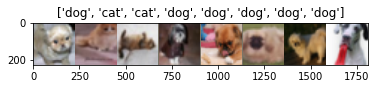

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

In order to get reproducible results, we set a manual seed for the random number generator and re-initialize the dataloaders.

In [ ]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

### Transfer Learning model on Classical dataset with Quantum-Classical layers

In [ ]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """
    for i in range(0, nqubits - 1, 2): # Loop over even indices: i=0,2,...N-2  
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1,2): # Loop over odd indices:  i=1,3,...N-3
        qml.CNOT(wires=[i, i + 1])

In [ ]:
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)
        
        # Embed features in the quantum node
        RY_layer(q_in)
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k+1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

We can now define a custom `torch.nn.Module` representing a *dressed* quantum circuit.<br>
The input of the module is a batch of vectors with 512 real parameters (features) and the output is a batch of vectors with *n* real outputs (one for each class of images).<br>

1. A classical pre-processing layer (`nn.Linear`)
2. A classical activation function (`F.tanh`)
3. A constant `np.pi/2.0` scaling factor.
4. The previously defined quantum circuit (`q_net`)
5. A classical post-processing layer (`nn.Linear`)


In [ ]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(512, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, len(filtered_classes))

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch, and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

In [ ]:
model_hybrid = torchvision.models.resnet18(pretrained=True)

for param in model_hybrid.parameters():
    param.requires_grad = False

model_hybrid.fc = Quantumnet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

In [ ]:
#Loss Function
criterion = nn.CrossEntropyLoss()

In [ ]:
#Optimizer
optimizer_hybrid = optim.Adam(model_hybrid.fc.parameters(), lr=step)

In [ ]:
#reduce the learning rate by a factor of `gamma_lr_scheduler` every epoch.
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=3, gamma=gamma_lr_scheduler)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        for epoch in range(num_epochs):
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    # Set model to training mode
                    scheduler.step()
                    model.train() 
                else:
                    # Set model to evaluate mode
                    model.eval()   
                
                # Iteration loop
                running_loss = 0.0
                running_corrects = 0
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, cifar_labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = torch.tensor(labels_to_filtered(cifar_labels))
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                            
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1
                
                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f} '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results             
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model

In [ ]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid, exp_lr_scheduler, num_epochs=num_epochs)

Training started:
Phase: train Epoch: 1/3 Loss: 0.5538 Acc: 0.7223             
Phase: val   Epoch: 1/3 Loss: 0.4698 Acc: 0.7560             
Phase: train Epoch: 2/3 Loss: 0.4800 Acc: 0.7769             
Phase: val   Epoch: 2/3 Loss: 0.4098 Acc: 0.8270             
Phase: train Epoch: 3/3 Loss: 0.4722 Acc: 0.7751             
Phase: val   Epoch: 3/3 Loss: 0.4039 Acc: 0.8165             
Training completed in 676m 5s
Best test loss: 0.4039 | Best test accuracy: 0.8270


In [ ]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0
model_hybrid.eval()

# Testing loop
for inputs, cifar_labels in dataloaders['val']:
    inputs = inputs.to(device)
    labels = torch.tensor(labels_to_filtered(cifar_labels))
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    print('Iter: {}/{}'.format(it+1,n_batches+1), end='\r', flush=True)
    it += 1
                    
# Print final results
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

Iter: 250/251
Test Loss: 0.4098 Test Acc: 0.8270        


### References

[1] Sasank Chilamkurthy. PyTorch transfer learning tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.
